In [2]:
import piff
import yaml

In [1]:
from astropy.io import fits
filepath = '/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0209/'
compressed_filename = 'DES0000+0209_r4907p01_r_nobkg.fits.fz'
uncompressed_filename = 'DES0000+0209_r4907p01_r_nobkg.fits'
# Open the compressed FITS file
uncompressed_filepath = filepath + compressed_filename
compressed_filepath = filepath + uncompressed_filename
with fits.open(uncompressed_filepath) as hdul:
    # Save it as a decompressed FITS file
    hdul.writeto(compressed_filepath, overwrite=True)

In [22]:
from astropy.io import fits

# Open the original FITS file with compressed HDUs
filepath = '/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0209/'
compressed_filename = 'DES0000+0209_r4907p01_r_nobkg.fits.fz'
uncompressed_filename = 'DES0000+0209_r4907p01_r_nobkg_decompressed.fits'
save_hdu = 1

with fits.open(filepath + compressed_filename) as hdul:
    # Create a new HDUList to store the decompressed HDUs
    decompressed_hdul = fits.HDUList()
    
    # Loop over each HDU in the original file
    for (i,hdu) in enumerate(hdul):
        # Check if the HDU is a compressed image and decompress it
        if isinstance(hdu, fits.CompImageHDU):
            decompressed_data = hdu.data  # Access the decompressed data
            decompressed_header = hdu.header  # Copy the header
            # Create a new ImageHDU with the decompressed data
            new_hdu = fits.ImageHDU(data=decompressed_data, header=decompressed_header)
            decompressed_hdul.append(new_hdu)
        else:
            # If it's not a compressed HDU, just copy it over
            decompressed_hdul.append(hdu)
        if i == save_hdu:
            break

    # Save the decompressed file
    decompressed_hdul.writeto(filepath + uncompressed_filename, overwrite=True)


In [21]:
with fits.open(filepath + compressed_filename) as hdul:
    # Loop over each HDU
    
    for i, hdu in enumerate(hdul):
        print(f"Header for HDU {i}:")
        print(hdu.header)


Header for HDU 0:
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                   16 / number of bits per data pixel                  NAXIS   =                    0 / number of data axes                            EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H CHECKSUM= '1fF73Z941dE41Z94'   / HDU checksum updated 2019-06-27T12:01:36       DATASUM = '         0'         / data unit checksum updated 2019-06-27T12:01:36 END                                                                                                                                                                                                                                                                                                                                                   

In [20]:
type(hdu[0])


astropy.io.fits.hdu.image.PrimaryHDU

In [14]:
hdu.EXTNAME

AttributeError: 'CompImageHDU' object has no attribute 'EXTNAME'

In [13]:
dir(hdu)

['_EXCLUDE',
 '_MASK',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_axes',
 '_bitpix',
 '_bscale',
 '_buffer',
 '_bzero',
 '_calculate_checksum',
 '_calculate_datasum',
 '_calculate_datasum_with_heap',
 '_char_encode',
 '_character_as_bytes',
 '_checksum',
 '_checksum_valid',
 '_clear_table_keywords',
 '_close',
 '_columns_type',
 '_compute_checksum',
 '_compute_hdu_checksum',
 '_data_loaded',
 '_data_needs_rescale',
 '_data_offset',
 '_data_replaced',
 '_data_size',
 '_data_type',
 '_datasum',
 '_datasum_valid',
 '_default_name',
 '_do_not_scale_image_data',
 '_dtype_for_bitpix',
 '_dump_coldefs',
 '_dump_data',
 '_encode_byte',
 '_ext_comment',
 '_extension',
 '

In [7]:
with fits.open(uncompressed_filepath) as hdul:
    for i, hdu in enumerate(hdul):
        if isinstance(hdu, fits.BinTableHDU):
            print(f"HDU {i}: {type(hdu)}")

HDU 1: <class 'astropy.io.fits.hdu.compressed.compressed.CompImageHDU'>
HDU 2: <class 'astropy.io.fits.hdu.compressed.compressed.CompImageHDU'>
HDU 3: <class 'astropy.io.fits.hdu.compressed.compressed.CompImageHDU'>


In [4]:
with fits.open(uncompressed_filepath) as hdul:
    # Iterate over all Header Data Units (HDUs) in the file
    for i, hdu in enumerate(hdul):
        print(f"Header for HDU {i}: ======================================================")
        print(repr(hdu.header))  # Print the header for each HDU

Header for HDU 0: ======================================================
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CHECKSUM= '1fF73Z941dE41Z94'   / HDU checksum updated 2019-06-27T12:01:36       
DATASUM = '         0'         / data unit checksum updated 2019-06-27T12:01:36 
Header for HDU 1: ======================================================
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of d

In [5]:
with fits.open('/path/to/your/file.fits') as hdul:
    for i, hdu in enumerate(hdul):
        print(f"HDU {i}: {type(hdu)}")

FileNotFoundError: [Errno 2] No such file or directory: '/path/to/your/file.fits'

In [22]:
config = """

input:
    
    # dir is optional.  If set, it applies to all file names here without an absolute path
    dir: /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0040-3249/
        
    # Define the input image with the pixel data.
    # These data come with a bad pixel mask and a weight map.
    image_file_name: DES0040-3249_r4907p01_g_nobkg.fits.fz
    image_hdu: 1
    badpix_hdu: 2
    weight_hdu: 3
        
    # Define the input catalog.
    cat_file_name: DES0040-3249_dr2_main.fits
        
    # Either (x,y) or (ra,dec) are required columns saying where the objects are.
    x_col: XWIN_IMAGE
    y_col: YWIN_IMAGE
        
    # If flags is set, it will ignore flagged rows.
    #flag_col: FLAGS
        
    # You can optionally specify any other columns you want to read.
    # These will be saved as additional properties of each star, which may be used in various ways.
    #property_cols: [SPREAD_MODEL]
        
    # This sets how large a stamp to pull out of the full image for each input object.
    stamp_size: 53


select:
    # The default is to use all input objects as candidate stars.
    # Here we refine that a bit by selecting rows based on the SExtractor "SPREAD_MODEL" value.
    # SPREAD_MODEL is a measure of how much bigger an object is than the SExtractor software's estimate
    # of the PSF size, so objects with SPREAD_MODEL close to zero are likely stars.
    type: Properties
        
    # This can be any eval-able string.
    # As mentioned, here we use the SPREAD_MODEL property we read in from the input catalog.
    #where: "np.abs(SPREAD_MODEL) < 3.e-4"
        
    # Mark 20% of stars as "reserve" stars.  Don't use them for fitting.                     
    # In machine learning lingo, this would be a validation set.
    reserve_frac: 0.2   
        
    # Specifying a seed makes the choice of reserve stars deterministic.  
    # Typically set on the command line, since you'd want this to be different for each image.
    seed: 1234   
        
    # Remove >3 sigma outlier in the HSM-measured size.
    # HSM (Hirata, Seljak and Mandelbaum) is an adaptive moment algorithm for measuring size and shapes, 
    # which is pretty stable and is included with GalSim.
    hsm_size_reject: 3   
        
    # Remove objects with estimated S/N < 50
    min_snr: 50    

    type: SizeMag

    initial_select:
        type: SmallBright
        bright_fraction: 0.3
        small_fraction: 0.3
        locus_fraction: 0.5
    fit_order: 3      


psf:
    model:
        type: PixelGrid
        scale: 0.27
        size: 32

    interp:
        type: BasisPolynomial
        order: 3
            
    outliers:
        # After the 2nd and subsequent iterations, look for outliers whose fits have a bad chisq value.
        # This is really defined in terms of a chisq probability distribution falling below some value,
        # but for convenience we let that probability be set in terms of "nsigma" using the 1-d Gaussian
        # probability distribution meaning for n sigma.
        type: Chisq
        nsigma: 4

output:
    # For now, just output the file with the PSF solution.  We'll add more to this section below.
    dir: output
    file_name: D00572501_z_c01.piff  
"""


In [23]:
config = yaml.safe_load(config)

In [24]:
config

{'input': {'dir': '/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0040-3249/',
  'image_file_name': 'DES0040-3249_r4907p01_g_nobkg.fits.fz',
  'image_hdu': 1,
  'badpix_hdu': 2,
  'weight_hdu': 3,
  'cat_file_name': 'DES0040-3249_dr2_main.fits',
  'x_col': 'XWIN_IMAGE',
  'y_col': 'YWIN_IMAGE',
  'stamp_size': 53},
 'select': {'type': 'SizeMag',
  'reserve_frac': 0.2,
  'seed': 1234,
  'hsm_size_reject': 3,
  'min_snr': 50,
  'initial_select': {'type': 'SmallBright',
   'bright_fraction': 0.3,
   'small_fraction': 0.3,
   'locus_fraction': 0.5},
  'fit_order': 3},
 'psf': {'model': {'type': 'PixelGrid', 'scale': 0.27, 'size': 32},
  'interp': {'type': 'BasisPolynomial', 'order': 3},
  'outliers': {'type': 'Chisq', 'nsigma': 4}},
 'output': {'dir': 'output', 'file_name': 'D00572501_z_c01.piff'}}

In [76]:
piff.piffify(config)

Using the same catlist for all image
Reading in 5 images


Getting wcs from image file /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0040-3249/DES0040-3249_r4907p01_Y_nobkg.fits.fz
Getting wcs from image file /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0040-3249/DES0040-3249_r4907p01_g_nobkg.fits.fz
Getting wcs from image file /nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0040-3249/DES0040-3249_r4907p01_i_nobkg.fits.fz


KeyboardInterrupt: 

In [53]:
psf = piff.read('../data_generation/piff_outputs/DES0040-3249.piff')

In [66]:
with open("../conf/piff_conf.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [73]:
config["output"]

{'file_name': './data_generation/piff_outputs/DES0040-3249.piff',
 'stats': [{'type': 'SizeMag', 'file_name': 'sizemag.png'}]}

In [72]:
config["output"]["file_name"] = '../data_generation/piff_outputs/DES0040-3249.piff'
piff.plotify(config)

Looking for PSF at ./data_generation/piff_outputs/DES0040-3249.piff
Reading PSF from file ./data_generation/piff_outputs/DES0040-3249.piff


OSError: FITSIO status = 104: could not open the named file
failed to find or open the following file: (ffopen)
./data_generation/piff_outputs/DES0040-3249.piff


In [74]:
config["file_name"] 

'../data_generation/piff_outputs/DES0040-3249.piff'

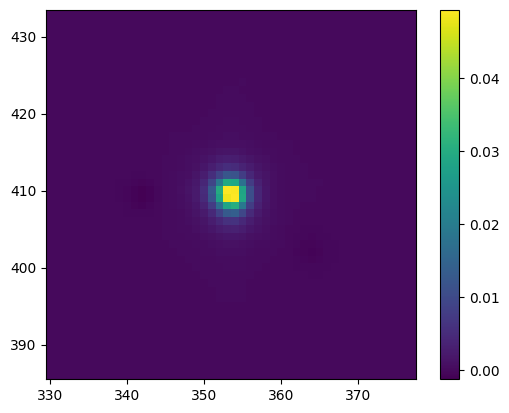

In [28]:
import matplotlib.pyplot as plt

im1 = psf.draw(353.3, 409.6, chipnum=0, center=True)

fig, ax = plt.subplots()
extent = (im1.bounds.xmin-0.5, im1.bounds.xmax+0.5, im1.bounds.ymin-0.5, im1.bounds.ymax+0.5)
c = ax.imshow(im1.array, origin='lower', extent=extent)
fig.colorbar(c)
plt.show()


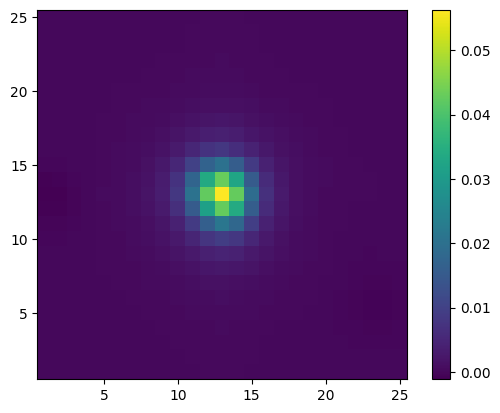

In [32]:
import galsim

im2 = psf.draw(353.3, 409.6, chipnum=3, center=True, image=galsim.Image(25,25))

fig, ax = plt.subplots()
extent = (im2.bounds.xmin-0.5, im2.boundsSo the f.xmax+0.5, im2.bounds.ymin-0.5, im2.bounds.ymax+0.5)
c = ax.imshow(im2.array, origin='lower', extent=extent)
fig.colorbar(c)
plt.show()

In [1]:
from astropy.io import fits


In [ ]:
# Open the FITS file
fits_file = fits.open('/data/scratch/des/piff_test_data//file.fits')

# To inspect the HDUs in the file
fits_file.info()

# Access the primary HDU (the first HDU, which often contains the main image)
primary_hdu = fits_file[0]

# Access the data part of the primary HDU (e.g., the image data)
image_data = primary_hdu.data

# Access the header part of the primary HDU
header = primary_hdu.header


In [3]:
import pandas as pd

datos = pd.read_csv("/data/scratch/des/piff_test_data/catalogs/galsim_des_000.dat", sep=" ")

In [4]:
datos

,50.65779131448861,-40.2559457021929,1452.3688341311522,908.3467578364723,1.0,133.7718963623047,462.3544006347656,1319.4444580078125,1899.4163818359375,0.8563806117981918,0,-0.007809360249954393,-0.043502758795884354,-1.0,1,2.485065460205078,0.3955726623535156
0,50.651671,-40.261632,1368.597693,830.512345,1.0,519.897827,2237.993652,5338.397461,7742.604004,0.688920,0,0.087142,0.095812,-1.0,1,2.528732,0.403690
1,50.652251,-40.263104,1376.526765,810.367404,1.0,367.739532,1621.037598,3170.170410,3873.343018,0.671256,0,-0.050761,-0.004016,-1.0,1,2.338856,0.217508
2,50.633482,-40.256225,1119.612361,904.528633,1.0,81.773697,530.450012,1149.551758,1678.149414,0.798679,0,0.054246,-0.014238,-1.0,1,2.869787,0.410755
3,50.644986,-40.245054,1277.083642,1057.437254,1.0,623.953552,2843.172607,4954.219238,6575.897461,0.879129,0,0.005119,0.031845,-1.0,1,2.249557,0.307449
4,50.652282,-40.263601,1376.954931,803.563767,1.0,367.318573,1051.121582,2163.569092,2950.574707,0.751004,0,0.036908,0.043411,-1.0,1,1.925320,0.336840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,50.615241,-40.288462,869.936258,463.262374,0.0,231.487274,463.212097,634.692627,872.179626,0.725178,0,0.013863,0.259445,-1.0,1,1.095091,0.345106
4411,50.733292,-40.311912,2485.833902,142.272453,0.0,3.239513,105.839439,282.889893,648.738586,0.612042,0,-0.001288,0.132732,-1.0,0,4.852844,0.901131
4412,50.690914,-40.208394,1905.758428,1559.248088,0.0,404.191559,760.577026,1316.797729,620.902832,0.931641,0,-0.007384,-0.066988,-1.0,1,1.282330,-0.816238
4413,50.738432,-40.196758,2556.192374,1718.518103,0.0,804.812256,1382.158569,1368.502930,2026.507324,1.034068,0,0.023545,0.014864,-1.0,1,0.576378,0.426256
